In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from py_helper_functions import *

from datetime import datetime

from patsy.highlevel import dmatrices

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

In [2]:
def get_cleaned_data(src=None) -> pd.DataFrame:
    '''
    This function takes a path to a csv file, cleans it and returns the cleaned dataframe
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    if src:
        df = pd.read_csv(src)
    else:
        urls = ['https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment2/listings_1.csv', 'https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment2/listings_2.csv']
        dfs = []
        for url in urls:
            u_df = pd.read_csv(url)
            dfs.append(u_df)
        df = pd.concat(dfs, ignore_index=True)
    
    # Filter the data for:
    #
    # new apartment not on market so no need to care about reviews
    working_sample = df[['id','name','host_id','host_name','host_since','host_is_superhost','host_total_listings_count','host_has_profile_pic','host_identity_verified','neighbourhood_cleansed','property_type','room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews','review_scores_value','instant_bookable', 'license']
                        ][(df['price'].notna()) 
                        & (df['beds'].notna())
                        & (df['host_is_superhost'].notna())
                        & (df['host_since'].notna())
                        & (df['bathrooms_text'].notna())
                        & (df['room_type'] != 'Hotel room')
                        & (df['accommodates'] <= 6) & (df['accommodates'] >= 2)
                        & (df['neighbourhood_cleansed'].isin(['Palermo', 'Catania', 'Gravina di Catania', 'San Gregorio di Catania', 'Militello in Val di Catania', 'Messina', 'Taormina', 'Realmonte', 'Agrigento', 'Siracusa', 'Cefal', 'Monreale', 'Ragusa', 'Modica']))]
    
    # fill NA data for reviews with 0s
    working_sample['review_scores_value'].fillna(0, inplace=True)
    
    # fill NA data for bedrooms with 1s
    working_sample['bedrooms'].fillna(1, inplace=True)
    
    # fill NA data for license with NAN
    working_sample['license'].fillna('NAN', inplace=True)
    
    # add boolean variables from text columns
    working_sample['d_host_is_superhost'] = working_sample['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_has_profile_pic'] = working_sample['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_identity_verified'] = working_sample['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_instant_bookable'] = working_sample['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_has_license'] = working_sample['license'].apply(lambda x: 1 if x != 'NAN' else 0)
    
    # calculate host time
    working_sample['n_host_since'] = working_sample['host_since'].apply(lambda x: (pd.Timestamp('2023-03-31') - pd.Timestamp(x)).days)
    
    # convert price to numerical
    working_sample['price'] = working_sample['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
    
    # filter for price < 
    working_sample = working_sample[(working_sample['price'] <= 400)]
    
    # add numerical variable for number of bath
    working_sample['n_bathrooms'] = working_sample['bathrooms_text'].apply(lambda x: 0.5 if 'half-bath' in x.lower() else float(x.lower().split()[0]))
    
    # clean the property type and room type
    working_sample['property_type'] = working_sample['property_type'].apply(lambda x: x.lower().replace('entire ', '').replace('private room ', '').replace('shared room ', '').replace('room in ', '').replace('in ', ''))
    working_sample['room_type'] = working_sample['room_type'].apply(lambda x: x.lower())
    
    # add amenities columns
    working_sample['d_entertainment'] = working_sample['amenities'].apply(lambda x: 1 if 'tv' in x.lower() or 'game' in x.lower() or 'roku' in x.lower() or 'disney' in x.lower() or 'netflix' in x.lower() or 'nintendo' in x.lower() or'chromecast' in x.lower() or 'alexa' in x.lower() or 'sound' in x.lower() else 0)
    working_sample['d_wifi'] = working_sample['amenities'].apply(lambda x: 1 if 'wifi' in x.lower() else 0)
    working_sample['d_kitchenware'] = working_sample['amenities'].apply(lambda x: 1 if 'fridge' in x.lower() or 'freezer' in x.lower() or 'stove' in x.lower() or 'coffee' in x.lower() or 'oven' in x.lower() or 'blender' in x.lower() or 'grill' in x.lower() or 'dishwasher' in x.lower() else 0)
    working_sample['d_washer'] = working_sample['amenities'].apply(lambda x: 1 if ('washer' in x.lower() or 'dryer' in x.lower() or 'drying' in x.lower()) else 0)
    working_sample['d_sauna_hot_tub'] = working_sample['amenities'].apply(lambda x: 1 if 'sauna' in x.lower() or 'tub' in x.lower() else 0)
    working_sample['d_pool'] = working_sample['amenities'].apply(lambda x: 1 if ' pool' in x.lower() or 'Pool' in x else 0)
    working_sample['d_aircon'] = working_sample['amenities'].apply(lambda x: 1 if 'air con' in x.lower() else 0)
    working_sample['d_heating'] = working_sample['amenities'].apply(lambda x: 1 if 'heating' in x.lower() else 0)
    working_sample['d_scenic_view_access'] = working_sample['amenities'].apply(lambda x: 1 if 'view' in x.lower() or 'access' in x.lower() else 0)
    working_sample['d_parking'] = working_sample['amenities'].apply(lambda x: 1 if 'parking' in x.lower() or 'carport' in x.lower() else 0)
    working_sample['d_pets_allowed'] = working_sample['amenities'].apply(lambda x: 1 if 'pets allowed' in x.lower() else 0)
    working_sample['d_patio_balcony'] = working_sample['amenities'].apply(lambda x: 1 if 'patio' in x.lower() or 'balcony' in x.lower() else 0)
    working_sample['d_bodyshower'] = working_sample['amenities'].apply(lambda x: 1 if 'shampoo' in x.lower() or 'conditioner' in x.lower() or 'soap' in x.lower() or 'gel' in x.lower() else 0)
    
    # rename numerical and categorical columns to have prefix
    working_sample.rename(columns={
        'host_total_listings_count': 'n_host_total_listings_count',
        'accommodates': 'n_accommodates',
        'bedrooms': 'n_bedrooms',
        'beds': 'n_beds',
        'minimum_nights': 'n_minimum_nights',
        'maximum_nights': 'n_maximum_nights',
        'neighbourhood_cleansed': 'f_neighbourhood_cleansed',
        'property_type': 'f_property_type',
        'room_type': 'f_room_type',
        'review_scores_value': 'n_review_scores_value',
        'number_of_reviews': 'n_number_of_reviews'
    }, inplace=True)
    
    del df
    if not src:
        del dfs[0]
        del dfs[1]
        
    return working_sample

In [3]:
work_df = get_cleaned_data('listings.csv')
# work_df = get_cleaned_data()
work_df.shape;

In [4]:
categorical_columns = [col for col in work_df.columns if col.startswith("f_")]
numerical_columns = [col for col in work_df.columns if col.startswith("n_") or col.startswith("d_")]

In [5]:
# build interaction terms
# interactions = ['f_property_type*f_room_type',
#                 'n_accommodates*f_property_type',
#                 'n_accommodates*f_room_type',
#                 'f_property_type*f_neighbourhood_cleansed',
#                 'f_room_type*f_neighbourhood_cleansed',
#                 'n_accommodates*f_neighbourhood_cleansed'
#                 ]
interactions = []
for i in categorical_columns + numerical_columns:
    for k in categorical_columns + numerical_columns:
        if i == k or i+'*'+k in interactions or k+'*'+i in interactions:
            continue
        else:
            interactions.append(i + '*' + k)

In [6]:
# ols get train test split
def get_ols_train_test_split(data, lasso=False):
    if lasso:
        y_, ols_df = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns) + '+' + '+'.join(interactions), data, return_type="dataframe")
    else:
        y_, ols_df = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns), data, return_type="dataframe")
    ols_terms_list = ols_df.design_info.column_names
    ols_df['price'] = y_
    ols_data_train, ols_data_holdout = train_test_split(ols_df, train_size=0.7, random_state=42)
    return ols_data_train, ols_data_holdout, ols_terms_list

In [7]:
data_train, data_holdout = train_test_split(work_df, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((11368, 44), (4872, 44))

Simple OLS

In [8]:
ols_data_train, ols_data_holdout, ols_terms_list = get_ols_train_test_split(work_df)

start_time = datetime.now()
ols_model = LinearRegression().fit(ols_data_train[ols_terms_list], ols_data_train['price'])
ols_time = datetime.now() - start_time
ols_model

LinearRegression()

In [9]:
ols_rmse = mean_squared_error(ols_model.predict(ols_data_train.drop(columns=['price'])), ols_data_train['price'], squared=False)
ols_rmse

44.325430125194565

In [10]:
df_ols_var_coefs = pd.DataFrame(
    ols_model.coef_.tolist(),
    index=ols_terms_list,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3)).loc[
    lambda x: x.ols_coefficient != 0
]
df_ols_var_coefs['abs_ols_coefficient'] = df_ols_var_coefs["ols_coefficient"].apply(lambda x: x if x >= 0 else x * -1)
df_ols_var_coefs = df_ols_var_coefs.reset_index().rename(columns={'index': 'term'})
df_ols_var_coefs['grouped_term'] = df_ols_var_coefs['term'].apply(lambda x: x.split('[')[0])
# df_ols_var_coefs.sort_values(by="abs_ols_coefficient", ascending=False).iloc[:100]
df_ols_var_coefs.groupby(['grouped_term']).sum().sort_values(by="abs_ols_coefficient", ascending=False)[['ols_coefficient', 'abs_ols_coefficient']].iloc[:10]

,ols_coefficient,abs_ols_coefficient
grouped_term,,
f_property_type,-1418.163,1739.051
f_neighbourhood_cleansed,3.654,118.806
f_room_type,-47.960,47.960
d_pool,36.555,36.555
n_bathrooms,18.808,18.808
n_bedrooms,11.076,11.076
d_sauna_hot_tub,10.711,10.711
d_wifi,10.305,10.305
d_pets_allowed,-5.705,5.705


LASSO

In [11]:
# LASSO for OLS
def get_lasso_matrices(data):
    y_ = data['price']
    X_ = data[lasso_terms_list]
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_)
    return y_, X_

In [12]:
%%time
# get lasso data split
lasso_data_train, lasso_data_holdout, lasso_terms_list = get_ols_train_test_split(work_df, lasso=True)

# define model
lasso_model = ElasticNet(l1_ratio = 1, fit_intercept = True)

# define cv search
lasso_search = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(10, 55, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

# perform the search
y, X = get_lasso_matrices(lasso_data_train)

start_time = datetime.now()
lasso_results = lasso_search.fit(X, y)
lasso_time = datetime.now() - start_time

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .......................alpha=0.1;, score=-48.976 total time=  11.4s
[CV 2/5] END .......................alpha=0.1;, score=-44.718 total time=   9.6s
[CV 3/5] END .......................alpha=0.1;, score=-44.129 total time=  14.7s
[CV 4/5] END .......................alpha=0.1;, score=-44.360 total time=  15.1s
[CV 5/5] END .......................alpha=0.1;, score=-44.077 total time=  14.6s
[CV 1/5] END ......................alpha=0.15;, score=-47.726 total time=   7.0s
[CV 2/5] END ......................alpha=0.15;, score=-43.486 total time=   5.7s
[CV 3/5] END ......................alpha=0.15;, score=-43.641 total time=   8.6s
[CV 4/5] END ......................alpha=0.15;, score=-44.205 total time=   8.1s
[CV 5/5] END ......................alpha=0.15;, score=-43.785 total time=   6.7s
[CV 1/5] END .......................alpha=0.2;, score=-46.680 total time=   5.7s
[CV 2/5] END .......................alpha=0.2;, s

In [13]:
lasso_results.best_estimator_

ElasticNet(alpha=0.45, l1_ratio=1)

In [14]:
df_lasso_results = pd.DataFrame(lasso_results.cv_results_)[['param_alpha', 'rank_test_score', 'mean_test_score']]
df_lasso_results;

In [15]:
df_lasso_var_coefs = pd.DataFrame(
    lasso_results.best_estimator_.coef_.tolist(),
    index=lasso_terms_list,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]
df_lasso_var_coefs['abs_lasso_coefficient'] = df_lasso_var_coefs["lasso_coefficient"].apply(lambda x: x if x >= 0 else x * -1)
# df_lasso_var_coefs.sort_values(by="abs_lasso_coefficient", ascending=False).iloc[:30]
df_lasso_var_coefs = df_lasso_var_coefs.reset_index().rename(columns={'index': 'term'})
df_lasso_var_coefs['grouped_term'] = df_lasso_var_coefs['term'].apply(lambda x: x.split(':')[0].split('[')[0] + ':' + x.split(':')[1].split('[')[0] if ':' in x else x.split('[')[0])
df_lasso_grouped_var_coefs = df_lasso_var_coefs.groupby(['grouped_term']).sum()
df_lasso_grouped_var_coefs = df_lasso_grouped_var_coefs.reset_index()

In [16]:
# single term coef power 
df_lasso_grouped_var_coefs[(df_lasso_grouped_var_coefs['grouped_term'].str.contains(':')) == False].sort_values(by="abs_lasso_coefficient", ascending=False)[['grouped_term', 'lasso_coefficient', 'abs_lasso_coefficient']][:10];

In [17]:
# interaction coef power
df_lasso_grouped_var_coefs[(df_lasso_grouped_var_coefs['grouped_term'].str.contains(':'))].sort_values(by="abs_lasso_coefficient", ascending=False)[['grouped_term', 'lasso_coefficient', 'abs_lasso_coefficient']][:10];

Random Forest

In [18]:
# building preprocessing for pipeline
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

In [19]:
tune_grid = {"max_features": [8, 10, 12], "min_samples_leaf": [5, 10, 15]}

rfr = RandomForestRegressor(random_state = 42)

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [20]:
rf_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_random)], verbose=True
)

In [21]:
%%time
start_time = datetime.now()
rf_model = rf_pipe.fit(data_train[numerical_columns + categorical_columns], data_train['price'])
rf_time = datetime.now() - start_time
rf_model

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=8, min_samples_leaf=5;, score=-44.792 total time=   0.5s
[CV 2/5] END max_features=8, min_samples_leaf=5;, score=-42.007 total time=   0.5s
[CV 3/5] END max_features=8, min_samples_leaf=5;, score=-42.317 total time=   0.5s
[CV 4/5] END max_features=8, min_samples_leaf=5;, score=-43.736 total time=   0.5s
[CV 5/5] END max_features=8, min_samples_leaf=5;, score=-44.426 total time=   0.5s
[CV 1/5] END max_features=8, min_samples_leaf=10;, score=-45.568 total time=   0.4s
[CV 2/5] END max_features=8, min_samples_leaf=10;, score=-43.042 total time=   0.4s
[CV 3/5] END max_features=8, min_samples_leaf=10;, score=-43.365 total time=   0.4s
[CV 4/5] END max_features=8, min_samples_leaf=10;, score=-44.784 total time=   0.4s
[CV 5/5] END max_features=8, min_samples_leaf=10;, score=-45.450 total time=   0.4s
[CV 1/5] END max_features=8, min_s

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_neighbourhood_cleansed',
                                                   'f_property_type',
                                                   'f_room_type']),
                                                 ('num', 'passthrough',
                                                  ['n_host_total_listings_count',
                                                   'n_accommodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_minimum_nights',
                                                   'n_maximum_nights',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_value',
                                                   'd_ho...
                                                   'd_sauna_hot_tub', 'd_pool',
                                                   'd_aircon', 'd_heating',
                                                   'd_scenic_view_access',
                                                   'd_parking',
                                                   'd_pets_allowed',
                                                   'd_patio_balcony',
                                                   'd_bodyshower'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(random_state=42),
                              param_grid={'max_features': [8, 10, 12],
                                          'min_samples_leaf': [5, 10, 15]},
                              scoring='neg_root_mean_squared_error',
                              verbose=3))],
         verbose=True)

In [22]:
df_rf_model_cv_results = pd.DataFrame(rf_random.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
8,43.46,44.44,44.97
10,43.18,44.07,44.63
12,42.86,43.79,44.29


In [23]:
rf_random.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5, random_state=42)

Boosting

In [24]:
gbm = GradientBoostingRegressor(learning_rate=0.01, random_state = 42)

tune_grid = {"n_estimators": [200, 300, 500], "max_depth": [5, 10, 15], "min_samples_leaf": [5, 10, 15], "max_features": [8, 10, 12], 'min_samples_split': [10, 20, 30]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [25]:
%%time
start_time = datetime.now()
gbm_model = gbm_pipe.fit(data_train[numerical_columns + categorical_columns],data_train.price)
gbm_time = datetime.now() - start_time
gbm_model

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 4/5; 1/243] START max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200
[CV 4/5; 1/243] END max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=-45.987 total time=   1.0s
[CV 5/5; 2/243] START max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=300
[CV 5/5; 2/243] END max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=300;, score=-45.284 total time=   1.2s
[CV 2/5; 4/243] START max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200
[CV 2/5; 4/243] END max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200;, score=-44.610 total time=   0.8s
[CV 3/5; 5/243] START max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_neighbourhood_cleansed',
                                                   'f_property_type',
                                                   'f_room_type']),
                                                 ('num', 'passthrough',
                                                  ['n_host_total_listings_count',
                                                   'n_accommodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_minimum_nights',
                                                   'n_maximum_nights',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_value',
                                                   'd_ho...
                                                   'd_patio_balcony',
                                                   'd_bodyshower'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                                  random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10, 15],
                                          'max_features': [8, 10, 12],
                                          'min_samples_leaf': [5, 10, 15],
                                          'min_samples_split': [10, 20, 30],
                                          'n_estimators': [200, 300, 500]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [26]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_depth=15, max_features=10,
                          min_samples_leaf=5, min_samples_split=10,
                          n_estimators=500, random_state=42)

In [27]:
df_gbm_model_cv_results = pd.DataFrame(gbm_model_cv.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'param_max_depth', 'param_n_estimators', 'mean_fit_time', 'mean_test_score']]
df_gbm_model_cv_results.columns = ['max features', 'min node size', 'max depth', '# estimators', 'fit time', 'RMSE']
df_gbm_model_cv_results;

Diagnostic

RF

In [28]:
%%time
rf_result = permutation_importance(
    rf_pipe,
    data_holdout[numerical_columns + categorical_columns],
    data_holdout.price,
    n_repeats=10,
    random_state=42,
    # scoring="neg_root_mean_squared_error"
)
rf_result;

CPU times: user 15.6 s, sys: 321 ms, total: 16 s
Wall time: 16.2 s


In [29]:
df_rf_grouped_var_imp = (pd.DataFrame(
        rf_result.importances_mean,
        numerical_columns + categorical_columns)
                      .sort_values(by = 0, ascending = False)
                      .reset_index()
                      .rename(columns={'index': 'variable', 0: 'imp'}))
df_rf_grouped_var_imp['cumulative_imp'] = df_rf_grouped_var_imp.imp.cumsum()
# df_grouped_var_imp.style.format({
#     'imp': lambda x: f'{x:,.1%}',
#     'cumulative_imp': lambda x: f'{x:,.1%}'})
df_rf_grouped_var_imp

,variable,imp,cumulative_imp
0,d_pool,2.795254,2.795254
1,n_bathrooms,1.934013,4.729266
2,n_host_total_listings_count,1.710691,6.439957
3,f_neighbourhood_cleansed,1.674409,8.114366
4,n_bedrooms,1.451425,9.565791
5,n_accommodates,1.321440,10.887231
6,n_number_of_reviews,1.199858,12.087090
7,n_review_scores_value,0.939962,13.027052
8,f_property_type,0.847967,13.875019
9,n_host_since,0.564340,14.439359


In [30]:
%%time
gbm_result = permutation_importance(
    gbm_pipe,
    data_holdout[numerical_columns + categorical_columns],
    data_holdout.price,
    n_repeats=10,
    random_state=42,
    # scoring="neg_root_mean_squared_error"
)
gbm_result;

CPU times: user 46.7 s, sys: 278 ms, total: 47 s
Wall time: 47.7 s


In [31]:
df_gbm_grouped_var_imp = (pd.DataFrame(
        gbm_result.importances_mean,
        numerical_columns + categorical_columns)
                      .sort_values(by = 0, ascending = False)
                      .reset_index()
                      .rename(columns={'index': 'variable', 0: 'imp'}))
df_gbm_grouped_var_imp['cumulative_imp'] = df_gbm_grouped_var_imp.imp.cumsum()
df_gbm_grouped_var_imp;

RMSE training and testing

In [32]:
def get_time_delta(delta):
    return f'{delta.seconds // 60}m{delta.seconds % 60}s'

lasso_y_holdout, lasso_X_holdout = get_lasso_matrices(lasso_data_holdout)
diagnostic_df = pd.DataFrame({'Model': ['Simple OLS', 'LASSO', 'Random Forest', 'GBM'],
                              'Train RMSE': ['{:.4f}'.format(ols_rmse), '{:.4f}'.format(lasso_search.best_score_*-1), '{:.4f}'.format(rf_random.best_score_*-1), '{:.4f}'.format(gbm_model_cv.best_score_*-1)],
                              'Holdout RMSE': ['{:.4f}'.format(mean_squared_error(ols_model.predict(ols_data_holdout.drop(columns=['price'])), ols_data_holdout['price'], squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(lasso_search.predict(lasso_X_holdout), lasso_y_holdout, squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(rf_pipe.predict(data_holdout[numerical_columns + categorical_columns]), data_holdout['price'], squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(gbm_pipe.predict(data_holdout[numerical_columns + categorical_columns]), data_holdout['price'], squared=False))],
                              'Training time': [get_time_delta(ols_time), get_time_delta(lasso_time), get_time_delta(rf_time), get_time_delta(gbm_time)]
                              })
diagnostic_df

,Model,Train RMSE,Holdout RMSE,Training time
0,Simple OLS,44.3254,45.0598,0m0s
1,LASSO,43.8399,44.6080,4m28s
2,Random Forest,42.8592,43.2666,0m23s
3,GBM,40.1763,40.6920,7m39s


<p style="page-break-after:always;"></p>

## <center>Pricing Airbnb Apartments in Sicily, Italy</center>

### Introduction and Goal
This report investigates and explores the predictive models for forcasting Airbnb apartment prices in the top most populated and touristic cities in Sicily, Italy. The findings and models in this report will provide significant insights and help our client to price and operate small and middle size apartments hosting 2-6 guests. From the results, we will analyze and recommend the best model the client should use to price their company apartments. Since our client does not provide detailed information about the exact city and the rental purpose, this report will assume and focus on the most popular use case: leisure rentals in famous touristic cities in Sicily.

-----

### 1. Data

#### Data Preparation
The data in the report is the listing details of Sicily Airbnb apartments in March 2023 from http://insideairbnb.com/get-the-data/. Further data cleaning and filtering are applied to fit with our scope of analysis. The detailed steps are as follows:
1. Get the raw dataset (N = 51,679)
2. Apply filters (N = 16,240):
    - Drop observations with missing value in price, number of beds, number of bathrooms, apartment is instant bookable.
    - Exclude apartment type 'Hotel' as our client is not operating hotel rooms.
    - Only keep apartments accommodating for 2-6 guests.
    - Only keep apartments located in Palermo, Catania, Messina, Taormina, Realmonte, Agrigento, Siracusa, Cefal, Monreale, Ragusa and Modica.
    - Exclude some extreme price values (top 1%) by keeping observation with price <= $400.
3. Feature engineering (N = 16,240):
    - Fill 0s as values for observations with no rating values.
    - Fill 1s as values for observations with no bedrooms values as these are studios.
    - Fill 'NAN' as values for observations with no license values.
    - Create boolean values for super host, host has profile picture, host identity verified, apartment is instant bookable and host has license.
    - Convert listing duration from text to number of days before 31/03/2023.
    - Convert price from text to numerical values.
    - Derive number of bathrooms from the bathroom text descriptions.
    - Clean the property type to remove the redundant values of room type.
    - Derive various boolean variables for amenities from the amenities text descriptions.

From all the data features in the raw dataset, we will use a subset of the those as predictors with the following rationales:
- Profile photo, verification status, license and number of listings may influence price as host without those can price lower to attract guests.
- Room details (location, type of property and room, number of accommodations, bedrooms, bathrooms, reviews, amenities, instant bookable, number of allowed nights) are chosen as room with higher value in any of those features can demand higher price from intuition.
- Other features are excluded as they are presented in another predictors (like longitude) or are irrelevant to our scope.

#### Data Exploration

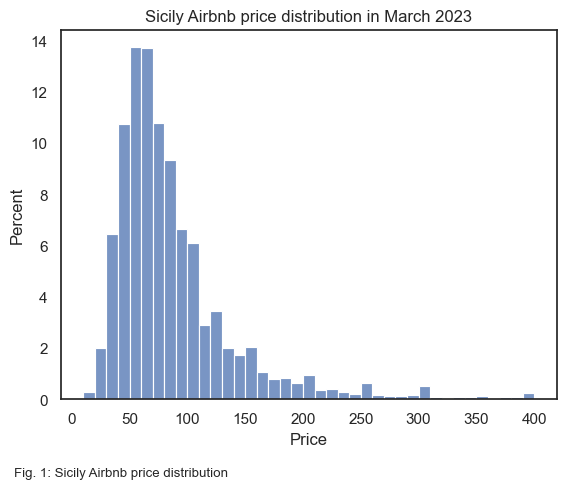

In [33]:
sns.set(style="white")
price_plot, ax3 = plt.subplots()
price_fig = sns.histplot(
    data = work_df,
    x = 'price', stat='percent', binwidth=10)
price_fig.set(title='Sicily Airbnb price distribution in March 2023', xlabel="Price")
ax3.text(-50, -3, 'Fig. 1: Sicily Airbnb price distribution', size=9.5)
price_plot.show()

From Fig. 1, it is clear that the price distribution is left-skewed. This means that the mean value price is not the typical value. Within this paper, the OLS models will assume that the mean is typical and will predict the mean value. It is worth noting that normally this is not the case and there might be impacts on the prediction results made by the OLS models.

### 2. Models
In this report, we will build 4 different models:
- Simple OLS model (OLS)
- Linear model with LASSO (LASSO)
- Random forest model (RF)
- Boosting with gradient descent model (GBM)

All models use the same set of features as discussed in the **Data** section, with the LASSO uses all possible combination of interaction terms. Since LASSO shrinks the coefficients for us and we do not know the interaction among the predictors from intuition, including all the interaction terms and letting the algorithm runs will leave us with a prediction model with the optimal choice of interactions through cross validation. Furthermore, all models, except for the simple OLS, will go through a 5-fold cross validation with different tuning parameters to optimize for overfitting.

The data used to train and validate is the same across all models. In this report, we will split the working data (N = 16,240) into the training set and the holdout set with the ratio of 7:3.

**Simple OLS**
This model is a linear model with predictors as the features selected in the **Data** section. No interation terms are included

**LASSO**
This linear model has predictors like the Simple OLS models but includes all possible combination of interaction terms. The tuning parameter is the penalty term $\alpha$ in range of [0.1, 0.5] inclusive, incremented by 0.05.

**Random Forest**
The random forest model includes all the selected features with no interaction as the random forest algorithm already handle the interation among predictors. The tuning parameters are:
- Maximum number of features for each split: [8, 10, 12]
- Minimum number of sample in each terminal node: [5, 10, 15]

**Boosting with Gradient Descent**
The boosting model includes features similar to the random forest model. The tuning parameters are:
- Learning rate: 0.01
- Number of estimators: [200, 300, 500], 
- Maximum tree depth: [5, 10, 15], 
- Maximum number of features for each split: [5, 10, 15], 
- Maximum number of features for each split: [8, 10, 12], 
- Minimum number of sample to continue splitting: [10, 20, 30]

### 3. Model evaluations

**Performances**
The performance result of each model are as follows:

In [34]:
diagnostic_df[['Model', 'Train RMSE', 'Training time']]

,Model,Train RMSE,Training time
0,Simple OLS,44.3254,0m0s
1,LASSO,43.8399,4m28s
2,Random Forest,42.8592,0m23s
3,GBM,40.1763,7m39s


The simple OLS model RMSE is the worst of all models, but it is not significantly worse than the LASSO and Random Forest models. Considering that the simple OLS completes almost instantly compared to the LASSO, the simple OLS might be better if speed is the top priority. However, the Random Forest model gives better result than the simple OLS while only take under half a minute to complete might be a more balance choice between accuracy and speed. The GBM model has the best accuracy and is significantly better than the rest of the models, but it also take significantly more time to finish. If accuracy is the top priority, the GBM model is the best model to go forward.

**Diagnostic**


In [35]:
df_ols_var_coefs.groupby(['grouped_term']).sum().sort_values(by="abs_ols_coefficient", ascending=False)[['ols_coefficient', 'abs_ols_coefficient']].iloc[:10]

,ols_coefficient,abs_ols_coefficient
grouped_term,,
f_property_type,-1418.163,1739.051
f_neighbourhood_cleansed,3.654,118.806
f_room_type,-47.960,47.960
d_pool,36.555,36.555
n_bathrooms,18.808,18.808
n_bedrooms,11.076,11.076
d_sauna_hot_tub,10.711,10.711
d_wifi,10.305,10.305
d_pets_allowed,-5.705,5.705


In [36]:
# single term coef power 
df_lasso_grouped_var_coefs[(df_lasso_grouped_var_coefs['grouped_term'].str.contains(':')) == False].sort_values(by="abs_lasso_coefficient", ascending=False)[['grouped_term', 'lasso_coefficient', 'abs_lasso_coefficient']][:10]

,grouped_term,lasso_coefficient,abs_lasso_coefficient
141,n_review_scores_value,-5.078,5.078
135,n_number_of_reviews,-2.003,2.003
29,f_neighbourhood_cleansed,1.986,1.986
57,f_property_type,0.943,1.003
17,d_pool,0.339,0.339
23,d_washer,-0.204,0.204


In [37]:
# interaction coef power
df_lasso_grouped_var_coefs[(df_lasso_grouped_var_coefs['grouped_term'].str.contains(':'))].sort_values(by="abs_lasso_coefficient", ascending=False)[['grouped_term', 'lasso_coefficient', 'abs_lasso_coefficient']][:10]

,grouped_term,lasso_coefficient,abs_lasso_coefficient
46,f_neighbourhood_cleansed:f_property_type,4.399,15.215
95,n_accommodates:n_bathrooms,7.831,7.831
70,f_property_type:d_pool,2.786,6.510
65,f_property_type:d_instant_bookable,1.787,5.481
71,f_property_type:d_sauna_hot_tub,4.334,5.284
88,f_room_type:n_bathrooms,-5.006,5.006
80,f_property_type:n_host_total_listings_count,3.692,4.960
96,n_accommodates:n_bedrooms,4.515,4.515
77,f_property_type:n_bathrooms,3.922,3.922
41,f_neighbourhood_cleansed:d_pool,-2.709,3.889


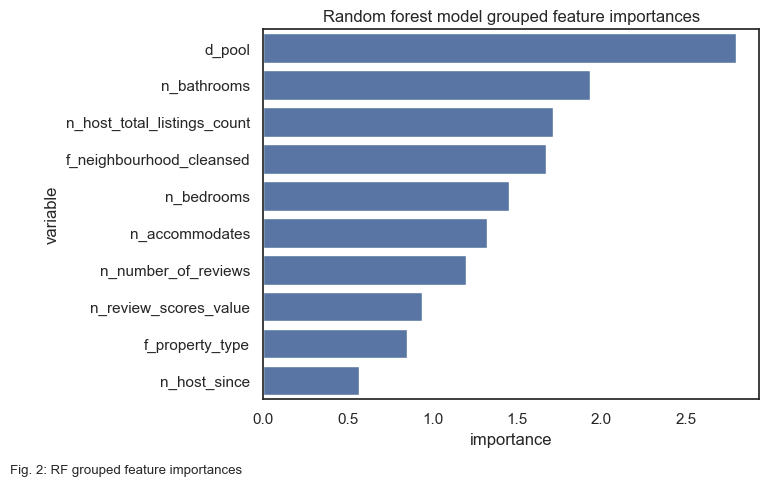

In [38]:
df_rf_grouped_var_imp = df_rf_grouped_var_imp.sort_values(by='imp', ascending=False)

sns.set(style="white")
rf_plot, ax1 = plt.subplots()
rf_fig = sns.barplot(
    data = df_rf_grouped_var_imp.iloc[0:10],
    x="imp", y="variable")
rf_fig.set(title='Random forest model grouped feature importances', xlabel="importance", ylabel="variable")
ax1.text(-1.5, 11.5, 'Fig. 2: RF grouped feature importances', size=9.5)
rf_plot.show()

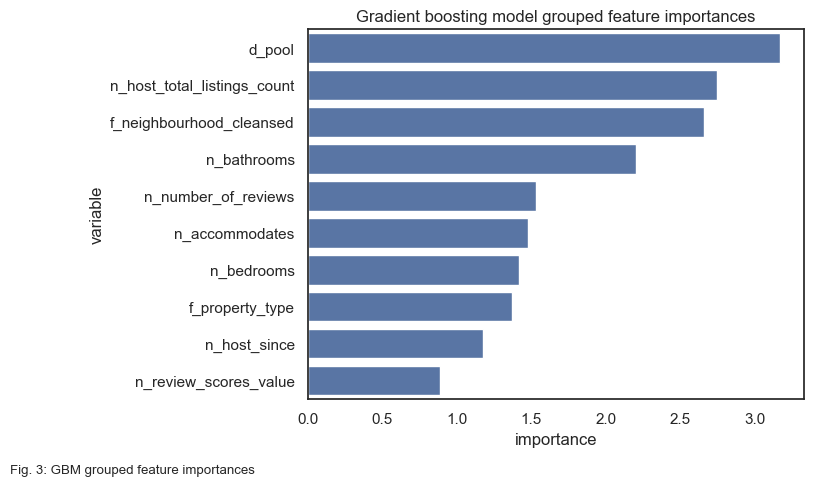

In [39]:
df_gbm_grouped_var_imp = df_gbm_grouped_var_imp.sort_values(by='imp', ascending=False)

sns.set(style="white")
gbm_plot, ax2 = plt.subplots()
gbm_fig = sns.barplot(
    data = df_gbm_grouped_var_imp.iloc[0:10],
    x="imp", y="variable")
gbm_fig.set(title='Gradient boosting model grouped feature importances', xlabel="importance", ylabel="variable")
ax2.text(-2, 11.5, 'Fig. 3: GBM grouped feature importances', size=9.5)
gbm_plot.show()